# Generating and Segmenting with Character-Level Transformer

In [77]:
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map

phoible = pd.read_csv('../../data/phoible.csv')

MODEL_NAME = 'phonemetransformers/childes-segmentation-2M-gpt2_lm-model'

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9400/3751781209.py:13: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../../data/phoible.csv')


In [78]:
import subprocess
import os

TMP_DIR = 'tmp'

def get_commits(repo_url):
    if not os.path.exists('tmp'):
        print(f"Cloning repository from {repo_url} into {TMP_DIR}...")
        subprocess.run(['git', 'clone', repo_url, TMP_DIR], check=True)
    else:
        print(f"Repository already exists at {TMP_DIR}.")

    os.chdir('tmp')  # Change to the repository directory
    print(f"Checking out repository...")
    subprocess.run(['git', 'checkout', 'main'], check=True)
    print("Finding all commit messages...")
    log = subprocess.run(['git', 'log', '--grep=Final model for experiment'], stdout=subprocess.PIPE, check=True)
    hashes = [line.split()[1] for line in log.stdout.decode().split('\n') if line.startswith('commit')]
    languages = [line.split()[-1] for line in log.stdout.decode().split('\n') if 'Final model for experiment' in line]
    print(f"Found {len(hashes)} final models in git history.")
    os.chdir('..')  # Change back to the parent
    print(f"Removing repository directory {TMP_DIR}...")
    subprocess.run(['rm', '-rf', TMP_DIR], check=True)
    return dict(zip(languages, hashes))

model_commits = get_commits( f'https://huggingface.co/{MODEL_NAME}.git')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'tmp'...


Cloning repository from https://huggingface.co/phonemetransformers/childes-segmentation-2M-gpt2_lm-model.git into tmp...


Filtering content: 100% (2/2), 18.45 MiB | 11.62 MiB/s, done.


Checking out repository...
Your branch is up to date with 'origin/main'.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Already on 'main'


Finding all commit messages...
Found 11 final models in git history.
Removing repository directory tmp...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load model

In [79]:
tokenizers = {}
models = {}
for language, commit in model_commits.items():
    print(f"{language}: {commit}")
    tokenizers[language] = AutoTokenizer.from_pretrained(MODEL_NAME, revision=commit)
    #phoneme_map = create_phoneme_map(tokenizers[language], '../../data/phoible.csv')
    models[language] = AutoModelForCausalLM.from_pretrained(MODEL_NAME, revision=commit)
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True

Mandarin: 51af82fe00250244aa67c0c3bcfa5fc39fd17e8d


tokenizer_config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Spanish: 45b36910c7726cb4630e6b9d9ba1591b2282bde6


vocab.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Serbian: 3fda75ae5e78e185e8e1332cc1573e7ac1fb9633


vocab.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Estonian: 8901a3b8a5eb0eab9fd8e197a3e79d2874737954


vocab.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.15k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

French: 772f8a92d4e5557a93e314eb54c932d7c010142b


vocab.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.66k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Dutch: 5eabdcb7ce3ccbbdb1980c860367d10435487dfd


vocab.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.84k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Indonesian: 972f74104d955993de4b3712b55ad50fb9dd8ac6


vocab.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

English: 279d3a45ea56f8441e41d15684714e71de2bb8e8


vocab.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Japanese: edf660c26545e87f55ee5ac060f9051c6ea4ebfc


vocab.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

EnglishUK: 45c9699efe56b3a5df3bf2d1a34da3a49bc5e473


vocab.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

German: 049149cf52bd3ba88bbebd2a40214a8b2f35b8d2


vocab.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

## Load corpus

In [80]:
from src.preprocessing import DataPreprocessingParams, DataPreprocessor
from src.config import DatasetParams
from src.utils import setup

def get_dataset_sample(language, num_tokens=50000):

    dataset_params = DatasetParams(subconfig=language, name='phonemetransformers/CHILDES', is_phonemes=True, remove_child_utterances=True, text_column='phonemized_utterance')
    data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts='static', remove_word_boundaries=True, subsample=num_tokens, subsample_type='tokens')
    data_preprocessor = DataPreprocessor(data_processing_params, tokenizer=tokenizers[language], get_word_boundaries=True)
    dataset = setup.load_dataset(dataset_params)
    dataset = dataset['train'].map(data_preprocessor, batched=True, remove_columns=["text"])
    return dataset

## Generate Text

In [81]:
def generate(language):
    # Generate a sample
    tokenizer = tokenizers[language]
    model = models[language]
    input_ids = tokenizer.encode('s', return_tensors='pt')
    print('Greedy decoding:')
    print(tokenizer.decode(model.generate(input_ids,
                                        max_length=50,
                                        pad_token_id=tokenizer.pad_token_id,
                                        early_stopping=False,
                                        eos_token_id=tokenizer.pad_token_id,
                                        no_repeat_ngram_size=3)[0], skip_special_tokens=False))

    print('Beam search decoding:')
    print(tokenizer.decode(model.generate(input_ids,
                                        do_sample=False,
                                        max_length=50,
                                        num_beams=4,
                                        pad_token_id=tokenizer.pad_token_id,
                                        early_stopping=False,
                                        eos_token_id=tokenizer.pad_token_id,
                                        no_repeat_ngram_size=3)[0], skip_special_tokens=False))

    print('Sampling decoding:')
    print(tokenizer.decode(model.generate(input_ids,
                                        do_sample=True,
                                        max_length=50,
                                        top_k=0,
                                        top_p=0.95,
                                        num_return_sequences=1,
                                        pad_token_id=tokenizer.pad_token_id,
                                        early_stopping=False,
                                        eos_token_id=tokenizer.pad_token_id,
                                        no_repeat_ngram_size=3)[0], skip_special_tokens=False))


# sample_outputs = model.generate(input_ids, do_sample=True, num_beams=4, max_length=50, top_k=10, top_p=0.95, num_return_sequences=1, pad_token_id=tokenizer.pad_token_id)
# for i, sample_output in enumerate(sample_outputs):
#     print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [82]:
from src.evaluation.segmentation import GPT2Segmenter

def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)

        cutoff = cutoffs[i] if cutoffs else None
        for jpos, j in enumerate(ax.get_xticks()):
            tick = ax.get_xticklabels()[jpos]
            is_boundary = data.Starts[j]
            y_value = data[measures[i]][j]
            # Add vertical line at boundary
            if is_boundary:
                ax.axvline(x=j, color='grey', alpha=0.5)
            # Set tick to green if correct boundary according to cutoff
            if cutoff:
                tick.set_color('green' if (is_boundary and y_value >= cutoff) or (not is_boundary and y_value < cutoff) else 'red')

        # Add cutoff line   
        if cutoff:
            ax.axhline(y=cutoff, color='pink', alpha=0.5)

    ax.set_xlabel('Phonemes')
    plt.show()

def get_cutoff_data(segmenter, measure, cutoffs):
    """ Get results for a specific measure at different cutoffs. """
    all_results = []
    for cutoff in cutoffs:
        results = segmenter.evaluate_cutoff_segmentation(measure, cutoff)
        results['Cutoff'] = cutoff
        all_results.append(results)
    all_results = pd.concat(all_results)
    return all_results

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = sns.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    sns.lineplot(results, x=measure1, y=measure2)
    plt.show()

def plot_optimal_cutoff(segmenter, measure, score, cutoff):

    min, max = segmenter.processed_utterances[measure].min(), segmenter.processed_utterances[measure].max()
    cutoffs = np.linspace(min, max, 50)
    scores = [segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score] for cutoff in cutoffs]
    graph = sns.lineplot(x=cutoffs, y=scores)
    graph.axvline(cutoff, color='grey', alpha=0.5)
    plt.show()

def summarise_segmentation(segmenter, measure='Entropy', score='type_fscore', cutoff=None, show_plots=False):
    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))
    if cutoff:
        best_cutoff = cutoff
        best_result = segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score]
    else:
        best_cutoff, best_result = segmenter.find_best_cutoff(measure, score)
        print('Best cutoff:', best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))
    if show_plots:
        plot_optimal_cutoff(segmenter, measure, score, best_cutoff)


In [83]:
dataset = get_dataset_sample('English', 10000)
segmenter = GPT2Segmenter(models['English'], tokenizers['English'], dataset, max_sequence_length=128, stride=2, subsample=50000)

all_measures = ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']
all_measures = ['Entropy', 'Boundary Prediction', 'Loss', 'Rank']
best_cutoffs = {measure : segmenter.find_best_cutoff(measure, 'boundary_noedge_fscore')[0] for measure in all_measures}

print("Best cutoffs: ", best_cutoffs)

Map:   0%|          | 0/1635797 [00:00<?, ? examples/s]

100%|██████████| 1563/1563 [02:19<00:00, 11.19it/s]


Best cutoffs:  {'Entropy': 1.4681103556886108, 'Boundary Prediction': 0.001424723630765701, 'Loss': 1.0666069147268638, 'Rank': 1.2809738289169685}


In [84]:
# segmenter.processed_utterances['Majority Vote Cutoff'] = 0
# segmenter.processed_utterances['Majority Vote Spike'] = 0
# for measure in all_measures:
#     segmenter.processed_utterances['Majority Vote Cutoff'] += (segmenter.processed_utterances[measure] >= best_cutoffs[measure]).astype(int)
#     shift_left = segmenter.processed_utterances[measure].shift(1)
#     shift_right = segmenter.processed_utterances[measure].shift(-1)
#     segmenter.processed_utterances['Majority Vote Spike'] += ((segmenter.processed_utterances[measure] > shift_left) & (segmenter.processed_utterances[measure] > shift_right)).astype(int)

segmenter.add_majority_vote(best_cutoffs)

best_cutoffs['Majority Vote Cutoff'] = 0.5
best_cutoffs['Majority Vote Spike'] = 0.5
all_measures += ['Majority Vote Cutoff', 'Majority Vote Spike']

In [85]:
example_utterance = segmenter.processed_utterances.iloc[0:64].copy()
example_utterance.Phoneme = example_utterance.Phoneme.apply(lambda x: x if x != 'UTT_BOUNDARY' else ' ')

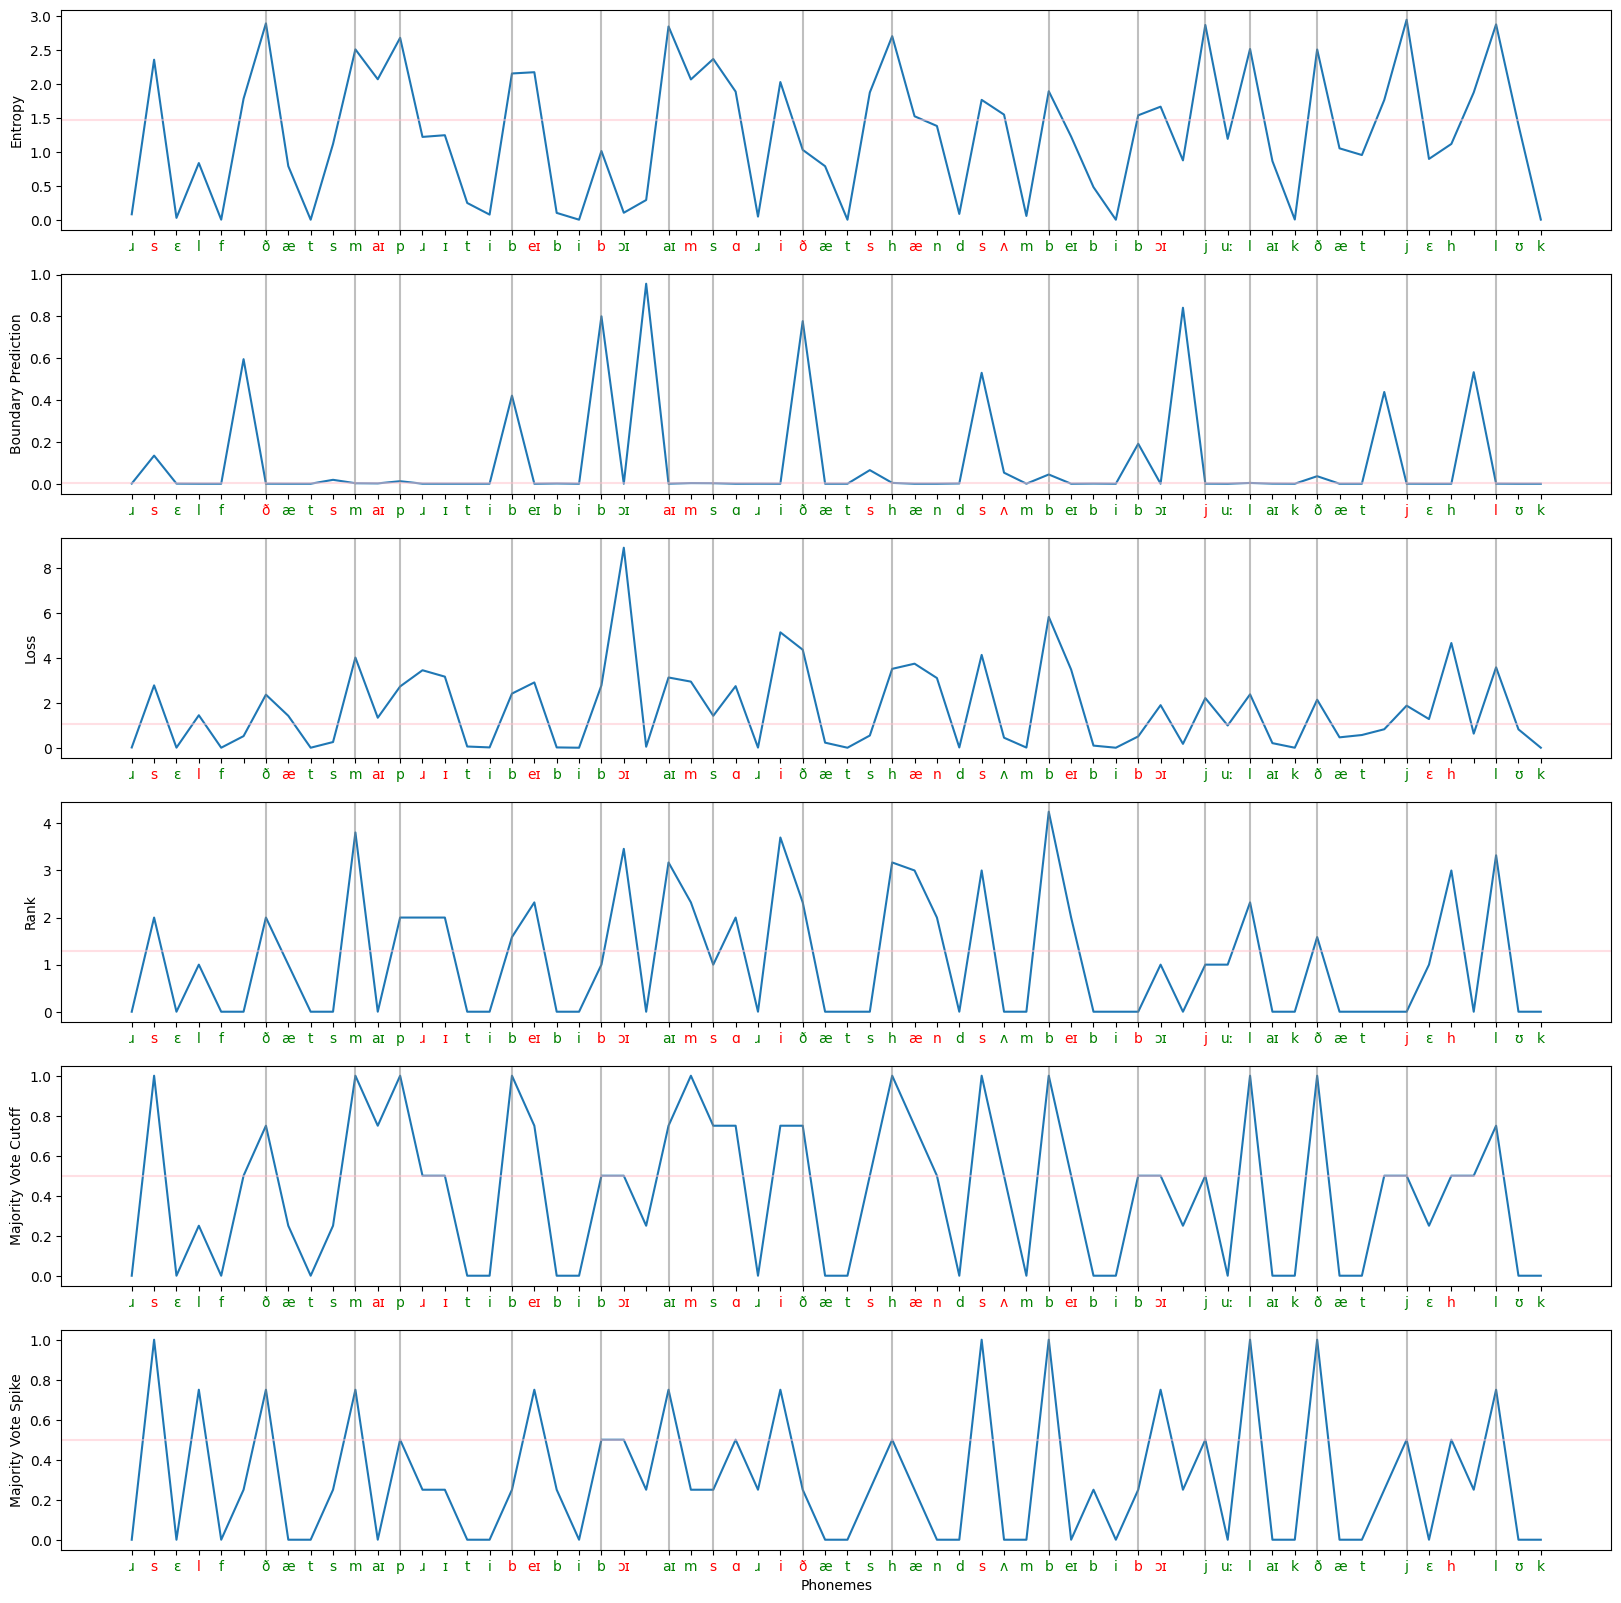

ɹsɛlf ðætsmaɪpɹɪtibeɪbibɔɪ aɪmsɑɹiðætshændsʌmbeɪbibɔɪ juːlaɪkðæt jɛh lʊk


In [86]:
plot_utterance(example_utterance, list(best_cutoffs.keys()), list(best_cutoffs.values()))
#plot_utterance(data, ['Feature Loss', 'Feature Entropy', 'Loss Deviation', 'Boundary Feature Prediction'], [0.01, 0.3, 0.01, 0.5])
print(''.join(list(example_utterance.Phoneme)))

In [87]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', best_cutoffs[measure], show_plots=False)
#for measure in ['Feature Loss', 'Increase in Feature Loss', 'Feature Entropy', 'Increase in Feature Entropy', 'Loss Deviation', 'Increase in Loss Deviation', 'Boundary Feature Prediction', 'Increase in Boundary Feature Prediction']:


Entropy
Spike type_fscore: 32.37
Best type_fscore at cutoff 1.4681103556886108: 29.02

Boundary Prediction
Spike type_fscore: 41.83
Best type_fscore at cutoff 0.001424723630765701: 37.71

Loss
Spike type_fscore: 28.62
Best type_fscore at cutoff 1.0666069147268638: 27.75

Rank
Spike type_fscore: 28.95
Best type_fscore at cutoff 1.2809738289169685: 24.87

Majority Vote Cutoff
Spike type_fscore: 36.92
Best type_fscore at cutoff 0.5: 33.52

Majority Vote Spike
Spike type_fscore: 32.05
Best type_fscore at cutoff 0.5: 36.67


In [88]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'boundary_noedge_fscore', show_plots=False)


Entropy
Spike boundary_noedge_fscore: 70.6
Best cutoff: 1.4681103556886108
Best boundary_noedge_fscore at cutoff 1.4681103556886108: 61.78

Boundary Prediction
Spike boundary_noedge_fscore: 77.62
Best cutoff: 0.001424723630765701
Best boundary_noedge_fscore at cutoff 0.001424723630765701: 72.65

Loss
Spike boundary_noedge_fscore: 64.4
Best cutoff: 1.0666069147268638
Best boundary_noedge_fscore at cutoff 1.0666069147268638: 57.15

Rank
Spike boundary_noedge_fscore: 59.25
Best cutoff: 1.2809738289169685
Best boundary_noedge_fscore at cutoff 1.2809738289169685: 53.76

Majority Vote Cutoff
Spike boundary_noedge_fscore: 75.07
Best cutoff: 0.5205878059280278
Best boundary_noedge_fscore at cutoff 0.5205878059280278: 65.5

Majority Vote Spike
Spike boundary_noedge_fscore: 71.96
Best cutoff: 0.3819714406912518
Best boundary_noedge_fscore at cutoff 0.3819714406912518: 74.14


In [89]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=False, cutoff=best_cutoffs['Majority Vote Cutoff'])
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=False, cutoff=best_cutoffs['Majority Vote Spike'])

Spike boundary_noedge_fscore: 75.07
Best boundary_noedge_fscore at cutoff 0.5: 65.5
Spike boundary_noedge_fscore: 71.96
Best boundary_noedge_fscore at cutoff 0.5: 73.46


In [90]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=False)
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=False)

Spike boundary_noedge_fscore: 75.07
Best cutoff: 0.5205878059280278
Best boundary_noedge_fscore at cutoff 0.5205878059280278: 65.5
Spike boundary_noedge_fscore: 71.96
Best cutoff: 0.3819714406912518
Best boundary_noedge_fscore at cutoff 0.3819714406912518: 74.14


# Correlation with units

In [91]:
def add_ends_to_segmenter(segmenter):
    ends = []
    max = len(segmenter.processed_utterances)
    for i in range(max):
        if i + 1 == max:
            ends.append(False)
        elif segmenter.processed_utterances['Phoneme'].iloc[i+1] == 'UTT_BOUNDARY':
            ends.append(True)
        elif segmenter.processed_utterances['Phoneme'].iloc[i] == 'UTT_BOUNDARY':
            ends.append(False)
        elif segmenter.processed_utterances['Starts'].iloc[i+1]:
            ends.append(True)
        else:
            ends.append(False)

    segmenter.processed_utterances['Ends'] = ends

In [92]:
import torch
from tqdm import tqdm
DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LEN = 64
STRIDE = 10

def get_activations(model, tokenizer, segmenter):

    boundary_token = tokenizer.convert_tokens_to_ids('UTT_BOUNDARY')
    phonemes = segmenter.processed_utterances['Phoneme'].to_list()

    token_ids = tokenizer.convert_tokens_to_ids(phonemes)
    long_input_ids = torch.tensor(token_ids, dtype=torch.long).to(DEFAULT_DEVICE)
    input_ids = []
    input_id_length = len(long_input_ids)
    for begin_loc in range(0, len(long_input_ids), STRIDE):
        end_loc = min(begin_loc + MAX_SEQ_LEN, len(long_input_ids))
        inputs = long_input_ids[begin_loc:end_loc].to(DEFAULT_DEVICE)
        input_ids.append(inputs)
        if end_loc == input_id_length:
            break

    # Pad final stride with 0s
    input_ids[-1] = torch.cat((input_ids[-1], torch.zeros(MAX_SEQ_LEN - len(input_ids[-1]), dtype=torch.long).to(DEFAULT_DEVICE)))

    # Stack into batches of batch_size
    input_ids = torch.stack(input_ids)
    input_ids = input_ids.view(-1, 1, MAX_SEQ_LEN)
    seq_len = input_ids.size(0)

    # Get activations from each batch and concatenate them
    activations = {}
    print('Extracting activations...')
    for i in tqdm(range(seq_len)):
        with torch.no_grad():
            outputs = model(input_ids[i], return_dict=True, output_hidden_states=True)
            if activations == {}:
                activations = {j : [] for j in range(sum([o.shape[-1] for o in outputs.hidden_states]))}
                for j, o in enumerate(outputs.hidden_states):
                    layer_size = o.shape[-1]
                    for k in range(o.shape[-1]):
                        activations[j*layer_size+k].extend(o[0,:,k].cpu().numpy())
            else:
                for j, o in enumerate(outputs.hidden_states):
                    layer_size = o.shape[-1]
                    for k in range(o.shape[-1]):
                        activations[j*layer_size+k].extend(o[0,-STRIDE:,k].cpu().numpy())
    activations = pd.DataFrame(activations)
    activations = activations[:len(token_ids)]
    return activations

def get_final_layer_size(model):
    return sum([o.shape[-1] for o in model([0], return_dict=True, output_hidden_states=True).hidden_states])

In [93]:
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

def get_correlations_to_individual_activations(segmenter, activations):
    # Find a correlation between the activations and Starts
    correlations = {}
    for column in activations.columns:
        correlations[column] = spearmanr(activations[column], segmenter.processed_utterances['Ends']).correlation
    correlations = pd.Series(correlations)

    # Ensure correlations are sorted correctly
    correlations = pd.Series(correlations).astype(float)  # Convert to float if not already
    correlations.sort_values(ascending=False, inplace=True)  # Sort in place

    return correlations

def train_one_parameter_classifier(segmenter, activations, plot=True):
    # Train a one parameter classifier that predicts word boundaries by thresholding the activations from a single unit in activations

    correlations = get_correlations_to_individual_activations(segmenter, activations)

    if abs(correlations[0]) > abs(correlations[correlations.index[-1]]):
        X = activations[correlations.index[0]].values.reshape(-1, 1)
        y = segmenter.processed_utterances['Ends'].values
    else:
        X = activations[correlations.index[-1]].values.reshape(-1, 1)
        y = ~segmenter.processed_utterances['Ends'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_train, X_train)

    # Calculate Youden's J statistic
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    # print(f'Optimal Threshold: {optimal_threshold}')

    y_pred = (X_test > optimal_threshold).astype(int)
    score = f1_score(y_test, y_pred)

    if plot:
        # Plot the activations and the classifier's predictions
        plt.figure(figsize=(20,10))
        plt.plot(X_test[90:150], alpha=0.5)
        plt.plot(y_test[90:150], alpha=0.5)
        plt.plot(y_pred[90:150], alpha=0.5)
        # add phonemes as x-axis labels
        plt.xticks(range(60), segmenter.processed_utterances['Phoneme'].values[90:150])
        plt.legend(['Activations', 'True Boundaries', 'Predicted Boundaries'])
        # Add cutoff
        plt.axhline(optimal_threshold, color='red', alpha=0.5)
        plt.show()

    return score

def train_probe(segmenter, activations, train_size=1000, val_size=10000):
    # Train a linear probe on the full final layer of the model

    X = activations.values
    y = segmenter.processed_utterances['Ends'].values

    # Remove positions where the phoneme is an utterance boundary
    X = X[segmenter.processed_utterances['Phoneme'] != 'UTT_BOUNDARY']
    y = y[segmenter.processed_utterances['Phoneme'] != 'UTT_BOUNDARY']

    # Shuffle
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    print('Train size:', len(X_train))
    print('Test size:', len(X_val))
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

    y_pred = clf.predict(X_val)

    return f1_score(y_val, y_pred)

def train_balanced_probe(segmenter, activations, train_size=1000, val_size=10000):
    # Train a linear probe on the full final layer of the model
    # with a carefully balanced training set
    
    y = segmenter.processed_utterances['Ends'].values
    phons = segmenter.processed_utterances['Phoneme'].values
    starts = segmenter.processed_utterances['Starts'].values

    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where((y == 0) & (phons != 'UTT_BOUNDARY'))[0]
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_train_idx = pos_idx[:train_size//2]
    neg_train_idx = neg_idx[:train_size//2]
    pos_idx = pos_idx[train_size//2:]
    neg_idx = neg_idx[train_size//2:]

    # Ensure test positions are not words in the training set
    pos_val_idx = []
    neg_val_idx = []
    for idx in pos_idx:
        word_exists = False
        for train_idx in pos_train_idx:
            i = 0
            while phons[train_idx - i] == phons[idx - i]:
                if starts[train_idx - i] == True and starts[idx - i] == True:
                    word_exists = True
                    break
                i += 1
            if word_exists:
                break
        if not word_exists:
            pos_val_idx.append(idx)
    for idx in neg_idx:
        word_exists = False
        for train_idx in neg_train_idx:
            i = 0
            while phons[train_idx - i] == phons[idx - i]:
                if starts[train_idx - i] == True and starts[idx - i] == True:
                    word_exists = True
                    break
                i += 1
            if word_exists:
                break
        if not word_exists:
            neg_val_idx.append(idx)

    train_idx = np.concatenate((pos_train_idx, neg_train_idx))
    np.random.shuffle(train_idx)

    true_val_size = np.min([len(pos_val_idx), len(neg_val_idx)])
    if true_val_size < val_size:
        raise ValueError('Not enough validation data available, only {} samples available.'.format(true_val_size))
    val_idx = np.concatenate((pos_val_idx[:val_size//2], neg_val_idx[:val_size//2]))
    np.random.shuffle(val_idx)

    print('Train size:', len(train_idx))
    print('Val size:', len(val_idx))

    X = activations.values
    y = segmenter.processed_utterances['Ends'].values

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

    y_pred = clf.predict(X_val)

    return accuracy_score(y_val, y_pred)


In [94]:
accuracies = {}
f1_scores = {}

In [95]:
for language in model_commits.keys():
    if language in accuracies:
        continue
    print(f"Generating for {language}...")
    dataset = get_dataset_sample(language, 100000)
    segmenter = GPT2Segmenter(models[language], tokenizers[language], dataset, max_sequence_length=128, stride=2, subsample=400000)
    add_ends_to_segmenter(segmenter)

    final_layer_size = models[language].transformer.config.n_embd
    activations = get_activations(models[language], tokenizers[language], segmenter)
    final_layer = activations[activations.columns[-final_layer_size:]]

    accuracies[language] = train_balanced_probe(segmenter, final_layer)
    print(accuracies[language])
    f1_scores[language] = train_probe(segmenter, final_layer)
    print(f1_scores[language])

Generating for Mandarin...


Map:   0%|          | 0/313940 [00:00<?, ? examples/s]

100%|██████████| 12501/12501 [2:21:45<00:00,  1.47it/s]  


Extracting activations...


100%|██████████| 39995/39995 [12:22<00:00, 53.89it/s]


Train size: 1000
Val size: 10000
0.8676
Train size: 1000
Test size: 10000
0.8938193343898574
Generating for Spanish...


Map:   0%|          | 0/278372 [00:00<?, ? examples/s]

100%|██████████| 12501/12501 [25:02<00:00,  8.32it/s]


Extracting activations...


100%|██████████| 39995/39995 [11:55<00:00, 55.91it/s]


Train size: 1000
Val size: 10000
0.8556
Train size: 1000
Test size: 10000
0.8257076731351255
Generating for Serbian...


Map:   0%|          | 0/216266 [00:00<?, ? examples/s]

  0%|          | 60/12501 [00:05<19:29, 10.63it/s]


KeyboardInterrupt: 

In [96]:
df = pd.DataFrame({'Accuracy': accuracies, 'F1 Score': f1_scores})
filename = f'probe_results_{MODEL_NAME.split("/")[-1]}.csv'
df.to_csv(filename)
